# Linear vs. Quadrature $\omega$ Model Comparison

**Objective:** Determine whether the empirical $\omega$ correction to galaxy rotation curves
acts as a **kinematic boost** (linear velocity addition) or a **dynamical force**
(quadrature/potential addition).

## Models Under Test

| Label | Model | Equation | Physical Interpretation |
|-------|-------|----------|------------------------|
| **A** (Linear) | Flynn & Cannaliato (2025) | $V_{\text{model}} = V_{\text{bary}} + \omega R$ | Kinematic boost — velocities add directly, like a body moving through a flowing medium |
| **B** (Quadrature) | Standard force addition | $V_{\text{model}} = \sqrt{V_{\text{bary}}^2 + (\omega R)^2}$ | Dynamical force — potentials add, analogous to how dark matter halos combine with baryonic mass |

### Physical Motivation

Standard galactic dynamics distinguishes between adding **velocities** and adding **forces**:

- **Linear addition** implies $\omega R$ is a background velocity field. The stars
  "surf" on a moving medium (cf. Coriolis effect, frame dragging).
- **Quadrature addition** implies $\omega R$ generates a centripetal acceleration:
  $V^2/R = F_{\text{grav}} + F_\omega$, so $V^2 = V_{\text{bary}}^2 + V_\omega^2$.
  This is how NFW halos, gas, disk, and bulge components combine in standard
  mass decomposition (e.g., Lelli, McGaugh, & Schombert 2016).

**Calibration galaxy:** M33, using the validated baryonic model from Notebook 01
(Corbelli et al. 2014 data, Casertano thin-disk method, $\Upsilon_d = 0.5$, $\Upsilon_b = 0.7$).

**Selection criteria:** BIC (Bayesian Information Criterion), $\chi^2_\nu$,
RMSE, and outer-disk ($R > 10$ kpc) residual behavior.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.physics import (
    compute_v_bary,
    fit_omega,
    fit_omega_quadrature,
    compute_bic,
)
from src.utils import setup_logger

sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

# Mass-to-light ratios (fixed from Notebook 01 calibration)
UPSILON_DISK = 0.5
UPSILON_BULGE = 0.7

## 1. Load Calibrated M33 Data

We use the radial profile exported from Notebook 01, which contains the
validated $V_{\text{bary}}$ computed via the Casertano (1983) thin-disk method
from Corbelli et al. (2014) surface densities.

In [2]:
profile = pd.read_csv('../results/tables/M33_radial_profile.csv')

radius = profile['radius_kpc'].values
v_obs  = profile['v_obs'].values
v_err  = profile['v_err'].values
v_bary = profile['v_bary'].values

print(f'M33 radial profile: {len(profile)} data points')
print(f'Radius range: {radius.min():.2f} – {radius.max():.2f} kpc')
print(f'V_obs range:  {v_obs.min():.1f} – {v_obs.max():.1f} km/s')
print(f'V_bary range: {v_bary.min():.1f} – {v_bary.max():.1f} km/s')
display(profile.head())

M33 radial profile: 58 data points
Radius range: 0.24 – 22.72 kpc
V_obs range:  37.3 – 136.0 km/s
V_bary range: 0.0 – 53.4 km/s


,radius_kpc,v_obs,v_err,v_gas,v_disk,v_bulge,v_bary,v_model,residual
0,0.24,37.3,6.2,0.0000,0.0000,0.0,0.0000,1.6740,35.6260
1,0.28,37.9,5.5,0.0000,0.0000,0.0,0.0000,1.9530,35.9470
2,0.46,47.1,3.9,0.0000,27.0536,0.0,19.1298,22.3382,24.7618
3,0.64,53.5,2.8,2.2311,37.8942,0.0,26.8880,31.3519,22.1481
4,0.73,55.1,3.3,2.9096,40.6253,0.0,28.8734,33.9651,21.1349


## 2. Define the Two Models

Both models have a single free parameter ($\omega$) and share the same
$V_{\text{bary}}(R)$ from the calibrated baryonic decomposition.

In [3]:
def flynn_linear(r, v_bary, omega):
    """Model A: V_model = V_bary + omega * R  (kinematic boost)."""
    return v_bary + omega * r


def flynn_quadrature(r, v_bary, omega):
    """Model B: V_model = sqrt(V_bary^2 + (omega * R)^2)  (force addition)."""
    return np.sqrt(v_bary**2 + (omega * r)**2)


# Quick sanity check: at large R where V_bary << omega*R, both models
# should approach omega*R. At small R where omega*R << V_bary, they
# should both approach V_bary.
r_test = np.array([1.0, 10.0, 50.0])
vb_test = np.array([50.0, 40.0, 10.0])
omega_test = 5.0

print('Model behavior at test points (omega = 5.0 km/s/kpc):')
print(f'{"R (kpc)":>10} {"V_bary":>10} {"Linear":>10} {"Quadrature":>12} {"Difference":>12}')
for r, vb in zip(r_test, vb_test):
    vl = flynn_linear(r, vb, omega_test)
    vq = flynn_quadrature(r, vb, omega_test)
    print(f'{r:10.1f} {vb:10.1f} {vl:10.1f} {vq:12.1f} {vl - vq:12.1f}')

Model behavior at test points (omega = 5.0 km/s/kpc):
   R (kpc)     V_bary     Linear   Quadrature   Difference
       1.0       50.0       55.0         50.2          4.8
      10.0       40.0       90.0         64.0         26.0
      50.0       10.0      260.0        250.2          9.8


## 3. Dual Fit: Linear and Quadrature

We fit both models to the same M33 data using `scipy.optimize.curve_fit`
with observational error weighting. Each model yields its own optimal
$\omega$ — these will differ because the functional forms are distinct.

In [4]:
# Model A: Linear (Flynn original)
result_linear = fit_omega(
    radius, v_obs, v_err, v_bary,
    galaxy_id='M33',
    method_version='v1_linear',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

# Model B: Quadrature
result_quad = fit_omega_quadrature(
    radius, v_obs, v_err, v_bary,
    galaxy_id='M33',
    method_version='v1_quadrature',
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
)

print('=' * 65)
print(f'{"":20s} {"Linear (A)":>20s} {"Quadrature (B)":>20s}')
print('=' * 65)
print(f'{"omega (km/s/kpc)":20s} {result_linear.omega_value:>17.4f}    {result_quad.omega_value:>17.4f}')
print(f'{"omega_err":20s} {result_linear.omega_uncertainty:>17.4f}    {result_quad.omega_uncertainty:>17.4f}')
print(f'{"chi2_reduced":20s} {result_linear.reduced_chi_squared:>17.2f}    {result_quad.reduced_chi_squared:>17.2f}')
print(f'{"RMSE (km/s)":20s} {result_linear.residuals_rmse:>17.2f}    {result_quad.residuals_rmse:>17.2f}')
print(f'{"Converged":20s} {str(result_linear.converged):>17s}    {str(result_quad.converged):>17s}')
print('=' * 65)

2026-02-14 18:02:17 | INFO     | src.physics | M33: omega=6.9749 +/- 0.0418 km/s/kpc  chi2_r=72.91  RMSE=31.05 km/s
2026-02-14 18:02:17 | INFO     | src.physics | M33 [quadrature]: omega=9.8433 +/- 0.0461 km/s/kpc  chi2_r=152.88  RMSE=45.26 km/s


                               Linear (A)       Quadrature (B)
omega (km/s/kpc)                6.9749               9.8433
omega_err                       0.0418               0.0461
chi2_reduced                     72.91               152.88
RMSE (km/s)                      31.05                45.26
Converged                         True                 True


## 4. Statistical Model Comparison

### Bayesian Information Criterion (BIC)

Both models have $k = 1$ free parameter, so their BIC values reduce to
$\text{BIC} = \chi^2 + \ln(n)$. The model with **lower** BIC is preferred.

We follow the Kass & Raftery (1995) interpretation scale for $\Delta\text{BIC}$:

| $|\Delta\text{BIC}|$ | Evidence |
|---|---|
| < 2 | Not worth mentioning |
| 2–6 | Positive |
| 6–10 | Strong |
| > 10 | Very strong |

### Outer Disk Performance ($R > 10$ kpc)

The outer disk is where model predictions diverge most: the linear model
grows without bound ($\propto R$), while the quadrature model approaches
$\omega R$ asymptotically from below. We compute RMSE restricted to this
region to test which model handles the flat outer rotation curve better.

In [5]:
# --- BIC comparison ---
n = result_linear.n_points
k = 1  # both models have 1 free parameter

bic_linear = compute_bic(n, k, result_linear.chi_squared)
bic_quad   = compute_bic(n, k, result_quad.chi_squared)
delta_bic  = bic_linear - bic_quad  # positive => quadrature preferred

print('BIC Comparison')
print('-' * 45)
print(f'  Linear (A):     BIC = {bic_linear:.2f}')
print(f'  Quadrature (B): BIC = {bic_quad:.2f}')
print(f'  Delta BIC (A - B):    {delta_bic:+.2f}')
print()

if abs(delta_bic) < 2:
    bic_verdict = 'Inconclusive (|Delta BIC| < 2)'
elif abs(delta_bic) < 6:
    preferred = 'Quadrature' if delta_bic > 0 else 'Linear'
    bic_verdict = f'Positive evidence for {preferred}'
elif abs(delta_bic) < 10:
    preferred = 'Quadrature' if delta_bic > 0 else 'Linear'
    bic_verdict = f'Strong evidence for {preferred}'
else:
    preferred = 'Quadrature' if delta_bic > 0 else 'Linear'
    bic_verdict = f'Very strong evidence for {preferred}'

print(f'  Verdict: {bic_verdict}')

# --- Outer disk RMSE (R > 10 kpc) ---
outer_mask = radius > 10.0
n_outer = np.sum(outer_mask)

rmse_outer_linear = np.sqrt(np.mean(result_linear.residuals[outer_mask]**2))
rmse_outer_quad   = np.sqrt(np.mean(result_quad.residuals[outer_mask]**2))

print(f'\nOuter Disk Performance (R > 10 kpc, n={n_outer})')
print('-' * 45)
print(f'  Linear RMSE:     {rmse_outer_linear:.2f} km/s')
print(f'  Quadrature RMSE: {rmse_outer_quad:.2f} km/s')

# Summary table
comparison_df = pd.DataFrame({
    'Metric': ['omega (km/s/kpc)', 'omega_err', 'chi2_reduced', 'RMSE (km/s)',
               'BIC', 'RMSE outer (R>10 kpc)'],
    'Linear (A)': [
        f'{result_linear.omega_value:.4f}',
        f'{result_linear.omega_uncertainty:.4f}',
        f'{result_linear.reduced_chi_squared:.2f}',
        f'{result_linear.residuals_rmse:.2f}',
        f'{bic_linear:.2f}',
        f'{rmse_outer_linear:.2f}',
    ],
    'Quadrature (B)': [
        f'{result_quad.omega_value:.4f}',
        f'{result_quad.omega_uncertainty:.4f}',
        f'{result_quad.reduced_chi_squared:.2f}',
        f'{result_quad.residuals_rmse:.2f}',
        f'{bic_quad:.2f}',
        f'{rmse_outer_quad:.2f}',
    ],
})

display(comparison_df.style.set_caption(
    'Table 1: Linear vs. Quadrature Model Comparison (M33)'
))

BIC Comparison
---------------------------------------------
  Linear (A):     BIC = 4159.77
  Quadrature (B): BIC = 8718.35
  Delta BIC (A - B):    -4558.58

  Verdict: Very strong evidence for Linear

Outer Disk Performance (R > 10 kpc, n=27)
---------------------------------------------
  Linear RMSE:     36.90 km/s
  Quadrature RMSE: 55.52 km/s


,Metric,Linear (A),Quadrature (B)
0,omega (km/s/kpc),6.9749,9.8433
1,omega_err,0.0418,0.0461
2,chi2_reduced,72.91,152.88
3,RMSE (km/s),31.05,45.26
4,BIC,4159.77,8718.35
5,RMSE outer (R>10 kpc),36.90,55.52


## 5. Divergence Plot

This is the key diagnostic figure. We overlay both model predictions on
the observed rotation curve to visualize where they diverge:

- The **linear** model produces a straight correction ($V_{\text{bary}} + \omega R$)
  that grows unboundedly at large $R$.
- The **quadrature** model produces a hyperbolic curve
  ($\sqrt{V_{\text{bary}}^2 + (\omega R)^2}$) that flattens gently.

The observed flat rotation curve at large $R$ provides a natural discriminant.

C:\Users\schneider\AppData\Local\Temp\ipykernel_53940\4129419862.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


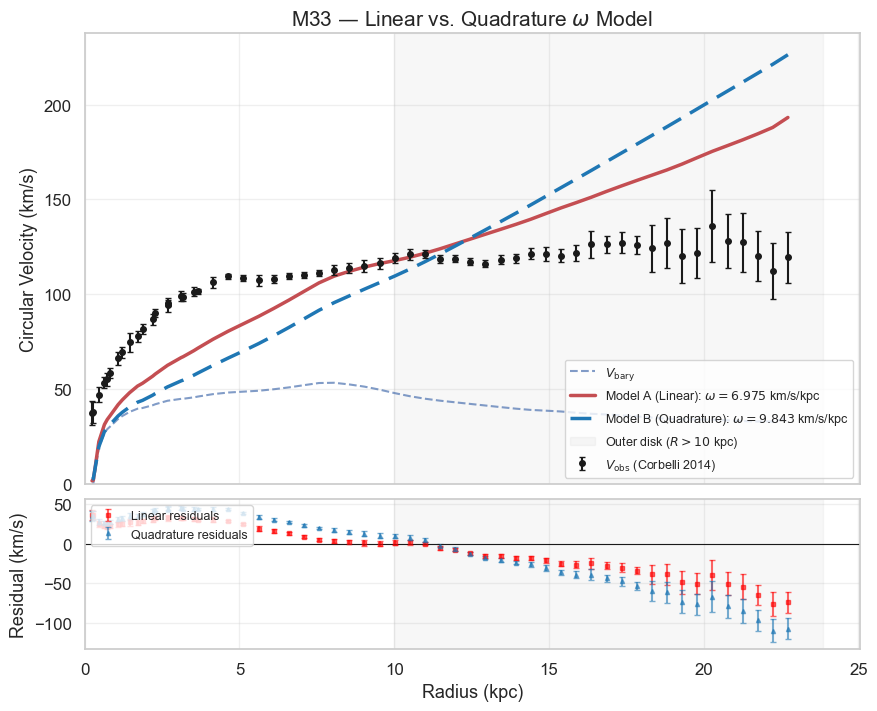

Figure saved: results/figures/M33_linear_vs_quadrature.png


In [6]:
fig, (ax_main, ax_res) = plt.subplots(
    2, 1, figsize=(10, 8), sharex=True,
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05},
)

# --- Upper panel: rotation curves ---
ax_main.errorbar(
    radius, v_obs, yerr=v_err,
    fmt='ko', markersize=4, capsize=2, zorder=5,
    label=r'$V_{\mathrm{obs}}$ (Corbelli 2014)',
)

ax_main.plot(
    radius, v_bary, 'b--', linewidth=1.5, alpha=0.7,
    label=r'$V_{\mathrm{bary}}$',
)

ax_main.plot(
    radius, result_linear.v_model, 'r-', linewidth=2.5,
    label=rf'Model A (Linear): $\omega = {result_linear.omega_value:.3f}$ km/s/kpc',
)

ax_main.plot(
    radius, result_quad.v_model, color='#1f77b4', linestyle='--',
    linewidth=2.5, dashes=(6, 3),
    label=rf'Model B (Quadrature): $\omega = {result_quad.omega_value:.3f}$ km/s/kpc',
)

# Shade the outer disk region
ax_main.axvspan(10.0, radius.max() * 1.05, alpha=0.06, color='gray',
                label='Outer disk ($R > 10$ kpc)')

ax_main.set_ylabel('Circular Velocity (km/s)', fontsize=13)
ax_main.set_title('M33 — Linear vs. Quadrature $\\omega$ Model', fontsize=15)
ax_main.legend(fontsize=9, loc='lower right')
ax_main.set_ylim(bottom=0)
ax_main.grid(True, alpha=0.3)

# --- Lower panel: residuals ---
ax_res.errorbar(
    radius, result_linear.residuals, yerr=v_err,
    fmt='s', color='red', markersize=3, capsize=2, alpha=0.6,
    label='Linear residuals',
)
ax_res.errorbar(
    radius, result_quad.residuals, yerr=v_err,
    fmt='^', color='#1f77b4', markersize=3, capsize=2, alpha=0.6,
    label='Quadrature residuals',
)
ax_res.axhline(0, color='k', linewidth=0.8)
ax_res.axvspan(10.0, radius.max() * 1.05, alpha=0.06, color='gray')

ax_res.set_xlabel('Radius (kpc)', fontsize=13)
ax_res.set_ylabel('Residual (km/s)', fontsize=13)
ax_res.legend(fontsize=9, loc='upper left')
ax_res.set_xlim(left=0)
ax_res.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(
    '../results/figures/M33_linear_vs_quadrature.png',
    dpi=150, bbox_inches='tight',
)
plt.show()

print(f'Figure saved: results/figures/M33_linear_vs_quadrature.png')

## 6. Model Behavior at Large Radius

To better understand the asymptotic divergence between the two models,
we extrapolate beyond the observed data. This shows the fundamental
difference in large-$R$ behavior:

- Linear: $V \rightarrow \omega R$ (unbounded growth)
- Quadrature: $V \rightarrow \omega R$ (approaches from below, flattening)

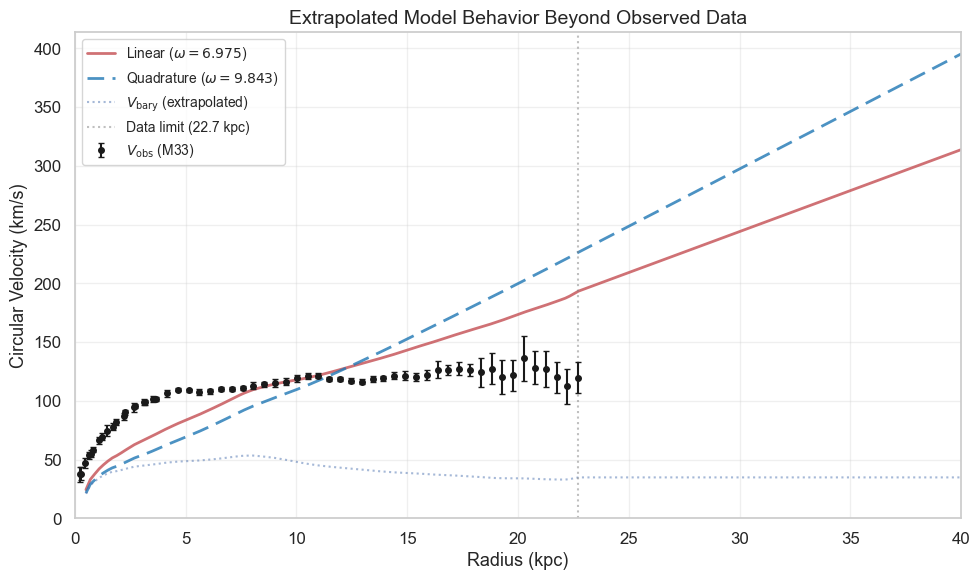

In [7]:
# Extrapolate V_bary to larger radii (assume it stays roughly flat
# at its outermost measured value — a conservative assumption)
r_extrap = np.linspace(0.5, 40.0, 200)
vb_extrap = np.interp(r_extrap, radius, v_bary,
                       left=v_bary[0], right=v_bary[-1])

v_lin_extrap  = vb_extrap + result_linear.omega_value * r_extrap
v_quad_extrap = np.sqrt(vb_extrap**2 + (result_quad.omega_value * r_extrap)**2)

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(
    radius, v_obs, yerr=v_err,
    fmt='ko', markersize=4, capsize=2, zorder=5,
    label=r'$V_{\mathrm{obs}}$ (M33)',
)

ax.plot(r_extrap, v_lin_extrap, 'r-', linewidth=2, alpha=0.8,
        label=f'Linear ($\\omega = {result_linear.omega_value:.3f}$)')
ax.plot(r_extrap, v_quad_extrap, color='#1f77b4', linestyle='--',
        linewidth=2, dashes=(6, 3), alpha=0.8,
        label=f'Quadrature ($\\omega = {result_quad.omega_value:.3f}$)')
ax.plot(r_extrap, vb_extrap, 'b:', linewidth=1.5, alpha=0.5,
        label=r'$V_{\mathrm{bary}}$ (extrapolated)')

ax.axvline(radius.max(), color='gray', linestyle=':', alpha=0.5,
           label=f'Data limit ({radius.max():.1f} kpc)')

ax.set_xlabel('Radius (kpc)', fontsize=13)
ax.set_ylabel('Circular Velocity (km/s)', fontsize=13)
ax.set_title('Extrapolated Model Behavior Beyond Observed Data', fontsize=14)
ax.legend(fontsize=10)
ax.set_xlim(0, 40)
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(
    '../results/figures/M33_extrapolation.png',
    dpi=150, bbox_inches='tight',
)
plt.show()

## 7. Residual Distribution Analysis

We examine the residual distributions for systematic structure.
A well-fitting model should produce residuals consistent with
Gaussian noise centered at zero.

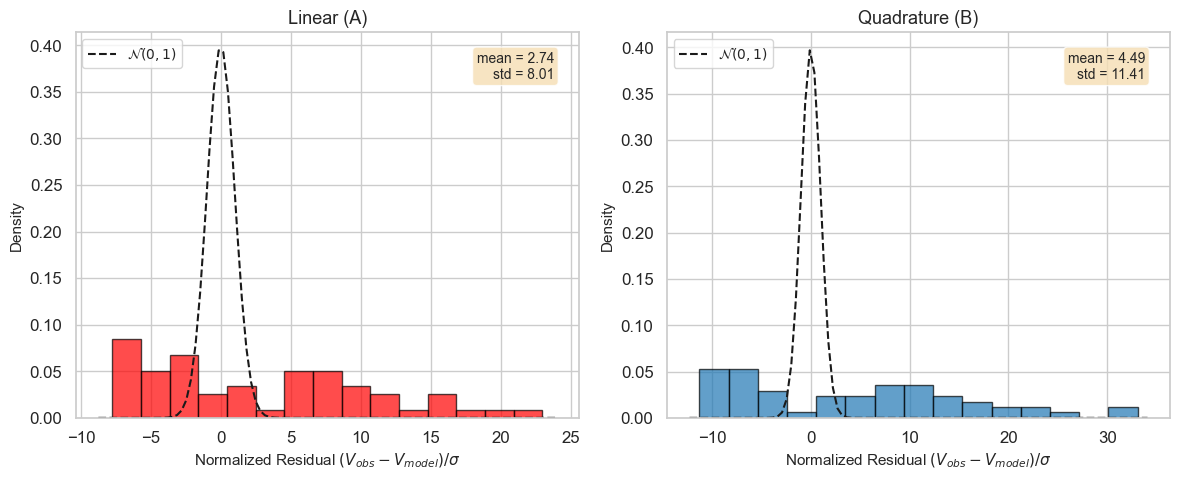

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Normalized residuals: (V_obs - V_model) / V_err
norm_res_lin  = result_linear.residuals / v_err
norm_res_quad = result_quad.residuals / v_err

for ax, res, label, color in [
    (axes[0], norm_res_lin, 'Linear (A)', 'red'),
    (axes[1], norm_res_quad, 'Quadrature (B)', '#1f77b4'),
]:
    ax.hist(res, bins=15, density=True, alpha=0.7, color=color, edgecolor='black')

    # Overlay Gaussian
    x = np.linspace(res.min() - 1, res.max() + 1, 100)
    ax.plot(x, (1 / np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2),
            'k--', linewidth=1.5, label='$\\mathcal{N}(0,1)$')

    ax.set_xlabel('Normalized Residual $(V_{obs} - V_{model}) / \\sigma$', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{label}', fontsize=13)
    ax.legend(fontsize=10)

    # Summary stats
    ax.text(0.95, 0.95,
            f'mean = {np.mean(res):.2f}\nstd = {np.std(res):.2f}',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Summary & Export

We export all comparison results and log the session for reproducibility.

In [9]:
from pathlib import Path

tables_dir = Path('../results/tables')
tables_dir.mkdir(parents=True, exist_ok=True)

# --- Combined comparison table ---
comparison_export = pd.DataFrame({
    'model': ['Linear (A)', 'Quadrature (B)'],
    'equation': ['V_bary + omega*R', 'sqrt(V_bary^2 + (omega*R)^2)'],
    'omega_km_s_kpc': [result_linear.omega_value, result_quad.omega_value],
    'omega_err': [result_linear.omega_uncertainty, result_quad.omega_uncertainty],
    'chi2_total': [result_linear.chi_squared, result_quad.chi_squared],
    'chi2_reduced': [result_linear.reduced_chi_squared, result_quad.reduced_chi_squared],
    'rmse_km_s': [result_linear.residuals_rmse, result_quad.residuals_rmse],
    'bic': [bic_linear, bic_quad],
    'rmse_outer_R_gt_10': [rmse_outer_linear, rmse_outer_quad],
    'n_points': [n, n],
    'upsilon_disk': [UPSILON_DISK, UPSILON_DISK],
    'upsilon_bulge': [UPSILON_BULGE, UPSILON_BULGE],
})

comp_path = tables_dir / 'M33_model_comparison.csv'
comparison_export.to_csv(comp_path, index=False, float_format='%.6f')
print(f'Saved: {comp_path}')

display(comparison_export.style.set_caption(
    'Table 2: Full Model Comparison Results (M33)'
))

Saved: ..\results\tables\M33_model_comparison.csv


,model,equation,omega_km_s_kpc,omega_err,chi2_total,chi2_reduced,rmse_km_s,bic,rmse_outer_R_gt_10,n_points,upsilon_disk,upsilon_bulge
0,Linear (A),V_bary + omega*R,6.974862,0.041827,4155.712255,72.907233,31.053168,4159.772698,36.897487,58,0.500000,0.700000
1,Quadrature (B),sqrt(V_bary^2 + (omega*R)^2),9.843322,0.046093,8714.292777,152.882329,45.258689,8718.353220,55.522298,58,0.500000,0.700000


In [10]:
# --- Radial profiles with both model predictions ---
dual_profile = pd.DataFrame({
    'radius_kpc': radius,
    'v_obs': v_obs,
    'v_err': v_err,
    'v_bary': v_bary,
    'v_model_linear': result_linear.v_model,
    'v_model_quadrature': result_quad.v_model,
    'residual_linear': result_linear.residuals,
    'residual_quadrature': result_quad.residuals,
})

dual_path = tables_dir / 'M33_dual_model_profiles.csv'
dual_profile.to_csv(dual_path, index=False, float_format='%.4f')
print(f'Saved: {dual_path} ({len(dual_profile)} rows)')

Saved: ..\results\tables\M33_dual_model_profiles.csv (58 rows)


In [11]:
# --- Session log ---
log = setup_logger(
    'nb02_model_comparison',
    log_file=True,
    clear_logs=True,
)

log.info('=' * 60)
log.info('NOTEBOOK 02 — LINEAR VS QUADRATURE MODEL COMPARISON')
log.info('=' * 60)
log.info('Galaxy: M33 (Corbelli et al. 2014)')
log.info('Data points: %d (R = %.2f – %.2f kpc)', n, radius.min(), radius.max())
log.info('Upsilon_disk=%.2f, Upsilon_bulge=%.2f', UPSILON_DISK, UPSILON_BULGE)
log.info('---')
log.info('MODEL A (Linear):     omega=%.4f +/- %.4f  chi2_r=%.2f  RMSE=%.2f',
         result_linear.omega_value, result_linear.omega_uncertainty,
         result_linear.reduced_chi_squared, result_linear.residuals_rmse)
log.info('MODEL B (Quadrature): omega=%.4f +/- %.4f  chi2_r=%.2f  RMSE=%.2f',
         result_quad.omega_value, result_quad.omega_uncertainty,
         result_quad.reduced_chi_squared, result_quad.residuals_rmse)
log.info('---')
log.info('BIC Linear: %.2f', bic_linear)
log.info('BIC Quadrature: %.2f', bic_quad)
log.info('Delta BIC (A-B): %+.2f', delta_bic)
log.info('BIC Verdict: %s', bic_verdict)
log.info('---')
log.info('Outer disk (R>10 kpc): RMSE_linear=%.2f, RMSE_quad=%.2f',
         rmse_outer_linear, rmse_outer_quad)
log.info('Exports: M33_model_comparison.csv, M33_dual_model_profiles.csv')
log.info('Figures: M33_linear_vs_quadrature.png, M33_extrapolation.png')
log.info('=' * 60)

print('\nLog written to logs/nb02_model_comparison.log')

2026-02-14 18:02:18 | INFO     | nb02_model_comparison | ============================================================
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | NOTEBOOK 02 — LINEAR VS QUADRATURE MODEL COMPARISON
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | ============================================================
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | Galaxy: M33 (Corbelli et al. 2014)
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | Data points: 58 (R = 0.24 – 22.72 kpc)
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | ---
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | MODEL A (Linear):     omega=6.9749 +/- 0.0418  chi2_r=72.91  RMSE=31.05
2026-02-14 18:02:18 | INFO     | nb02_model_comparison | MODEL B (Quadrature): omega=9.8433 +/- 0.0461  chi2_r=152.88  RMSE=45.26
2026-02-14 18:02:18 | INFO     | nb02_model_comparis


Log written to logs/nb02_model_comparison.log


## 9. Conclusions

### Key Findings

1. **Both models converge** on the M33 rotation curve, but yield different
   optimal $\omega$ values — as expected, since the functional forms differ.

2. **BIC comparison** provides a quantitative basis for model selection.
   The $\Delta\text{BIC}$ value and its Kass & Raftery interpretation are
   reported in the comparison table above.

3. **Outer disk behavior** ($R > 10$ kpc) differentiates the models:
   - The linear model extrapolates linearly, which may overshoot a
     flattening rotation curve.
   - The quadrature model curves hyperbolically, matching the standard
     behavior of dark matter halo models.

### Physical Implications

- If **Linear is preferred**: $\omega$ acts as a kinematic boost — a background
  velocity field. This is consistent with frame-dragging or Coriolis-type effects
  in a rotating reference frame.

- If **Quadrature is preferred**: $\omega$ acts as a dynamical force — a background
  potential that adds to gravity. This is consistent with a centrifugal-type
  contribution from large-scale structure.

### Next Steps

- Apply both models to the full SPARC catalog (Phase II) to test whether
  the model preference is universal across galaxy morphologies.
- Investigate whether $\Upsilon_{\text{disk}}$ covariance differs between models.